Importamos librerías y funciones necesarias

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ipynb.fs.full.Funciones_basicas import *
from ipynb.fs.full.Algoritmos import *
from ipynb.fs.full.Visualizaciones import *
#from ipynb.fs.defs.Script_jose_rob import quality_partition   

In [2]:
from gurobipy import *
import random

In [3]:
def find_order(G, V, sample, s):
    ans = []; Q = deque([]); Q.append(s)
    while Q:
        u = Q.popleft()
        if u in sample:
            ans.append(u)
            sample.remove(u)
        for v in G.predecessors(u):
            if not V[v]:
                Q.append(v)
    return ans

Instanciamos el grafo

In [4]:
path_geom = '../data/graph_geom_corrected_cycles.csv'
geometry = gpd.read_file(path_geom, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
     
path = '../data/corrected_dijkstra.csv'
csv_grafo = pd.read_csv(path, sep=',')

path_pesos = '../data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {1003950, 15004, 15131, 1003744, 15190, 1003746, 13730, 1003167, 13731, 13732, 13733, 14062, 1003206, 16503, 13735, 16094, 16095}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

Tree = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        Tree.add_edge(id_[origin], id_[dest])
        
G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G.add_edge(id_[origin], id_[dest])
    
N = l

W = [0] * N

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

## Prueba con diferentes grafos

### Grafo camino

In [5]:
T = nx.path_graph(20, create_using=nx.DiGraph()).reverse()
k = 2
root = 0
K_ = list(range(1, k + 1))
V = list(T.nodes())
N = len(V)
I = {(u, v): u in get_ideal(T, [0] * N, v) and u!=v for u in V for v in V}
#nx.draw_networkx(T)

### Árbol binario

In [ ]:
T = nx.DiGraph()
for i in range(1, 10):
    T.add_edge(2*i, i)
    T.add_edge(2*i + 1, i) 
k = 3
root = 1
K_ = list(range(1, k + 1))
V = list(T.nodes())
N = len(V)
I = {(u, v): u in get_ideal(T, [0] * (N + 1), v) and u!=v for u in V for v in V}
print(f'{N} nodos en el grafo')
nx.draw_networkx(T)

### Arbol de instancia con máxima profundidad

In [48]:
T = nx.DiGraph()
max_depth = 15
T = Tree.subgraph([node for node in list(Tree.nodes()) if nx.shortest_path_length(Tree, source = node, target = 744) <= max_depth])
k = 5
root = 744
K_ = list(range(1, k + 1))
V = list(T.nodes())
N = len(V)
print(f'{N} nodos en el grafo')

42 nodos en el grafo


In [49]:
I = dict()
for v in V:
    V_ =  get_ideal(T, [0] * 500 * N, v)
    for u in V:
        if u in V_ and u!=v:
            I[(u,v)] = 1
        else:
            I[(u,v)] = 0

In [50]:
alpha = dict()
alpha_hat = dict()
# combinations_alpha = [(2,1), (7,1), (8,7), (3,2), (4,3), (5,4), (6,4)]
# combinations_alpha_hat = combinations_alpha + [(5,3), (5,2), (5,1), (6,3), (6,2), (6,1), (4,2), (4,1), (3,1), (8,1)]
# Combinaciones DP
combinations_alpha = [(2,1), (7,1), (8,1), (3,2), (4,3), (5,2), (6,1)]
combinations_alpha_hat = combinations_alpha + [(5,1), (4,2), (4,1), (3,1)]
for i in range(1, k+1):
    for j in range(1,k+1):
        if (i,j) in combinations_alpha:
            alpha[(i,j)] = 1
            alpha_hat[(i,j)] = 1
        elif (i,j) in combinations_alpha_hat:
            alpha[(i,j)] = 0
            alpha_hat[(i,j)] = 1
        else:
            alpha[(i,j)] = 0
            alpha_hat[(i,j)] = 0

### Instanciación del modelo

In [51]:
model = gurobipy.Model("Muestreo")
x = model.addVars(V, K_, vtype = GRB.BINARY, name ="Nodos raices")
alpha_hat = model.addVars(K_, K_, vtype = GRB.BINARY, name ="Ideal descendiente")
alpha = model.addVars(K_, K_, vtype = GRB.BINARY, name ="Ideal hijo")
Z = model.addVar(vtype = GRB.CONTINUOUS , obj=1.0, name ="Ideal de mayor tamano")
y = model.addVars(K_, K_, vtype = GRB.CONTINUOUS, name ="Tamano Ideal hijo")


P = dict()
for j in K_:
    P[j] = quicksum(quicksum(x[u,j] * I[v,u] for v in V) for u in V)

model.addConstrs((P[j] - quicksum(y[r,j] for r in K_) <= Z for j in K_), name = "R1")
model.addConstrs((y[r,j]<= N * alpha[r,j]  for j in K_ for r in K_), name = "y-R1")
model.addConstrs((y[r,j]<= P[r]  for j in K_ for r in K_), name = "y-R2")
model.addConstrs((y[r,j]>= P[r] - (1-alpha[r,j])*N for j in K_ for r in K_), name = "y-R3")


model.addConstrs((quicksum(x[v,k]  for v in V) == 1 for k in K_), name = "R2")
model.addConstrs((quicksum(x[v,k]  for k in K_) <= 1 for v in V), name = "R3")
model.addConstrs((alpha_hat[r,k] >= x[u,r] + x[v,k] + I[u,v] - 2 for v in V for u in V for r in K_ for k in K_ ), name = "R4")

model.addConstrs((alpha[r,t] <= 2 - (alpha_hat[r,k] + alpha_hat[k,t]) for r in K_ for k in K_ for t in K_), name = "R5")
model.addConstr((quicksum(quicksum(alpha[r,t]  for r in K_) for t in K_) == k - 1), name = "R6")
model.addConstr((x[root,1] == 1), name = "R7")

model.addConstrs((alpha[r,k] <= alpha_hat[r,k] for r in K_ for k in K_), name = "R9")
model.addConstrs((2 - (x[u,r] + x[v,k]) + I[u,v] >= alpha_hat[r,k] for u in V for v in V for r in K_ for k in K_), name = "R10")
model.setObjective(Z, GRB.MINIMIZE)
model.update()
model.optimize()

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 88479 rows, 286 columns and 266741 nonzeros
Model fingerprint: 0xfa077cd0
Variable types: 26 continuous, 260 integer (260 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 68652 rows and 77 columns
Presolve time: 0.67s
Presolved: 19827 rows, 209 columns, 60577 nonzeros
Variable types: 0 continuous, 209 integer (192 binary)

Root relaxation: objective 0.000000e+00, 1105 iterations, 0.12 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   31          -    0.00000      -     -    1s
H    0     0                      30.0000000    0.00000   100%     -    1s
H    0     0                      25.0000000    0.00000   100%     -    1s
     0     0  

In [53]:
model.printAttr("x")
#print(list(model.getVars()))
#print('Optimal objective: %g' % model.objVal)
#elif model.status == GRB.INF_OR_UNBD:    print('Model is infeasible or unbounded')    sys.exit(0)elif model.status == GRB.INFEASIBLE:    print('Model is infeasible')    sys.exit(0)elif model.status == GRB.UNBOUNDED:    print('Model is unbounded')    sys.exit(0)
#model.computeIIS()
#model.write("model.mps")


    Variable            x 
-------------------------
Nodos raices[2319,3]            1 
Nodos raices[1431,4]            1 
Nodos raices[411,2]            1 
Nodos raices[422,5]            1 
Nodos raices[744,1]            1 
Ideal descendiente[2,1]            1 
Ideal descendiente[3,1]            1 
Ideal descendiente[3,2]            1 
Ideal descendiente[4,1]            1 
Ideal descendiente[4,2]            1 
Ideal descendiente[5,1]            1 
Ideal descendiente[5,2]            1 
Ideal descendiente[5,4]            1 
Ideal hijo[2,1]            1 
Ideal hijo[3,2]            1 
Ideal hijo[4,2]            1 
Ideal hijo[5,4]            1 
Ideal de mayor tamano           11 
Tamano Ideal hijo[2,1]           32 
Tamano Ideal hijo[3,2]            8 
Tamano Ideal hijo[4,2]           13 
Tamano Ideal hijo[5,4]            2 


In [20]:
y = {}
# y[2,1] = 353
# y[3,2] = 203
# y[4,3] = 105 
# y[5,2] = 65 
# y[6,1] = 103 
# y[7,1] = 82 
# y[8,1] = 89 
y[2,1] = 103
y[3,2] = 37
y[4,3] = 11 
y[5,2] = 23 
y[6,1] = 22 
y[7,1] = 2 
y[8,1] = 5 
for i in range(9):
    for j in range(9):
        if (i,j) not in y.keys():
            y[i,j] = 0

In [18]:
pl = [744, 2148, 320, 376, 422, 1046, 1430, 1432]
pl_2 = [744, 2162, 496, 1432, 422, 3663, 1873, 144]

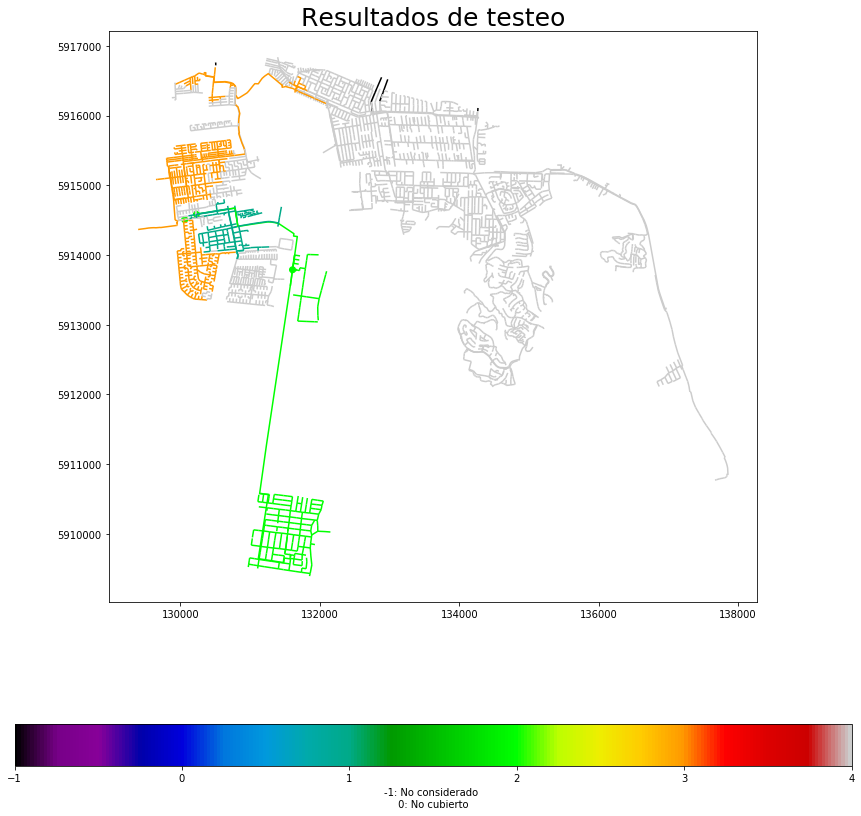

In [53]:
close = [node for node in list(Tree.nodes()) if nx.shortest_path_length(Tree, source = node, target = 744) <= max_depth]
V_ = [0 if node in close else 1 for node in range(len(Tree.nodes()))]
points = find_order(Tree, [0] * 500 * N, [744, 1430, 1433, 422], 744)[::-1]
plot_sample_no_intersections(Tree, V_, points, geometry, _id, 'IP')


In [52]:
find_order(T, [0] * 500 * N, [744, 2149, 1432, 2319], 744)[::-1]

[1432, 2319, 2149, 744]

In [55]:
def find_order(G, V, sample_, s):
    sample = sample_.copy()
    ans = []; Q = deque([]); Q.append(s)
    while Q:
        u = Q.popleft()
        if u in sample:
            ans.append(u)
            sample.remove(u)
        for v in G.predecessors(u):
            if not V[v]:
                Q.append(v)
    return ans

## Imitación de estructura de árbol obtenido por DP

In [49]:
nodes_ = [1001542, 13207, 13947, 15720, 13682, 13854, 15098, 14792] 
nodes = [id_[i] for i in nodes_]
for v in nodes:
    I_v = get_ideal(Tree, [0] * 500 * N, v)
    for u in nodes:
        if u in I_v and u != v:
            #print(u,v)
            pass

In [62]:
dp = [744, 1430, 422, 1433, 2162, 144, 1877, 900]
nodes, dp

([743, 1430, 2162, 3929, 1905, 2071, 3309, 3003],
 [744, 1430, 422, 1433, 2162, 144, 1877, 900])

In [50]:
#nodes = [id_[i] for i in dp]
for v in dp:
    I_v = get_ideal(Tree, [0] * 500 * N, v)
    for u in dp:
        if u in I_v and u != v:
            #print(u,v)
            pass

In [30]:
def quality_partition(G, solution, Max = True, Norm_2 = True):
    N = len(G.nodes()); M = 1e10; root = 743
    V = [0] * 10 * N
    ordered_solution = find_order(G, V, solution.copy(), root)
    sizes = get_sizes_partition(G, ordered_solution[::-1])

    max_partition = max(sizes) if Max else 0
    norm_2 = sum([i**2 for i in sizes]) if Norm_2 else 0
    
    if not Norm_2:
        return max_partition
    return M * max_partition + norm_2

def get_sizes_partition(G, solution_):
    N = len(G.nodes()); solution = solution_; root = 743
    V = [0] * 10 * N
    sizes = []
    if root not in solution:
        solution.append(root)
    for u in solution:
        sizes.append(get_size(G, V, u))
        V, _ = visit(G, V, u)
    #print(sizes)
    return sizes

In [47]:
quality_partition(T, pl_2, Max = True, Norm_2 = False), quality_partition(T, dp, Max = True, Norm_2 = False)


(106, 108)

In [63]:
find_order(T, [0] * 5000, dp, 744), find_order(T, [0] * 5000, pl_2, 744)
#dp, pl_2

([744, 1430, 422, 1433, 2162, 144, 1877, 900],
 [744, 1432, 422, 2162, 3663, 144, 496, 1873])